In [ ]:
# ============================================================================
# CELL 1: DATA LOADING AND PREPARATION
# ============================================================================
# GOAL:
# Loading toxicity data from Excel and preparing it for analysis.
#
# Different from the paper:
# - Our data is acute toxicity (LD50), while the paper's is repeat-dose (LEL/LOAEL)
# - We have fewer variables (4 vs. the paper's 10)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, rlm
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_excel("/content/drive/MyDrive/data/final_database_temporary1.xlsx")

# Rename the columns
df = df.rename(columns={
    'CASRN': 'casrn',
    'Species_Scientific_Name': 'species',
    'Qualifier': 'qualifier',
    'LD50_value_mg/kg bw': 'ld50',
    'Database_source': 'source',
    'Substance_purity_percentage': 'purity'
})
# Keep only the columns we need
df = df[['casrn', 'species', 'qualifier', 'ld50', 'source', 'purity']]

# Clean and standardize the 'species' column
df['species'] = df['species'].str.lower()
df['species'] = df['species'].str.replace('anas platyrhnchos', 'anas platyrhynchos')
df['species'] = df['species'].str.replace('unknown species', 'unknown')

# Clean and standardize the 'purity' column
df['purity'] = df['purity'].replace({
    '"unknown"': np.nan,     # Replace missing values w/ NaN for later imputation
    '[GB CRD 2021 dossier: >960 g/kg]': 96
})
# Extract numeric values from strings
df['purity'] = pd.to_numeric(
    df['purity'].astype(str)
    .str.replace(',', '.')
    .str.extract(r'(\d+\.?\d*)')[0],
    errors='coerce' # Invalid values become NaN
)
# Convert values over 100 to percent
purity_over_100 = df['purity'] > 100
df.loc[purity_over_100, 'purity'] = df.loc[purity_over_100, 'purity'] / 10
# Any values still over 100 are errors and should be removed
df.loc[df['purity'] > 100, 'purity'] = np.nan

# Remove rows without an LD50 value
df = df.dropna(subset=['ld50'])

# Log transform LD50 values
df['log10'] = np.log10(df['ld50'])

# Fill any remaining missing values
df['qualifier'] = df['qualifier'].fillna('=') # Assume exact value
df['species']   = df['species'].fillna('unknown')

# Sort the data by chemical ID for consistent ordering
df = df.sort_values(by='casrn').reset_index(drop=True)

# Print final dataset info
print(f"- Data loaded has {len(df)} records from {df['casrn'].nunique()} chemicals")
print(f"- Number of missing purity value: {df['purity'].isna().sum()}")

- Data loaded has 1480 records from 812 chemicals
- Number of missing purity value: 216


In [ ]:
# ============================================================================
# CELL 2: CREATE DATASETS FOR ANALYSIS
# ============================================================================
# GOAL:
# Preparing two distinct datasets for our analysis, each using a different
# definition of what makes a "replicate study".
#
# Datasets created and how:
# 1. MLR Dataset:
#    - Includes any chemical that has at least two measurements.
#    - Missing purity values are filled with the mean
#      purity of this entire MLR dataset. The purity is then centered.
#
# 2. ACM Dataset:
#    - First, we create "cells" (unique combinations of
#      chemical + species + source). Then, we keep only those cells that
#      have at least two measurements.
#    - Missing purity values are filled with the mean
#      purity of the ACM subset. The purity is then centered using
#      the ACM subset's mean.
# ============================================================================

# Filter for point estimates
point_estimates = df[
    (df['qualifier'].isin(['=', '~'])) |
    ((df['qualifier'].isin(['>=', '>'])) &
     (df['ld50'] == 2000))
].copy()

# ===========
# MLR DATASET
# ===========
# Keep chemicals with at least 2 measurements
mlr_data = point_estimates.groupby('casrn').filter(lambda x: len(x) >= 2).copy()

# Impute missing purity with the mean of the MLR dataset
mlr_purity_mean = mlr_data['purity'].mean()
mlr_data['purity'] = mlr_data['purity'].fillna(mlr_purity_mean)

# Center the purity variable by subtracting the MLR mean
mlr_data['purity_centered'] = mlr_data['purity'] - mlr_data['purity'].mean()

# Calculate total variance of the log10(LD50) values
mlr_variance = mlr_data['log10'].var()
mlr_n = len(mlr_data)

# ===========
# ACM DATASET
# ===========
# Create "cells" by combining chemical + species + source
acm_data = point_estimates.copy()
acm_data['cell'] = acm_data['casrn'] + '||' + acm_data['species'] + '||' + acm_data['source']

# Keep only cells that have at least 2 replicates
acm_data = acm_data.groupby('cell').filter(lambda x: len(x) >= 2).copy()

# Impute missing purity with the mean of the ACM dataset
acm_purity_mean = acm_data['purity'].mean()
acm_data['purity'] = acm_data['purity'].fillna(acm_purity_mean)

# Recenter purity for ACM dataset (using its own mean)
acm_data['purity_centered'] = acm_data['purity'] - acm_data['purity'].mean()

# Calculate variance for the ACM dataset
acm_variance = acm_data['log10'].var()
acm_n = len(acm_data)

# Print summaries
print(f"MLR Dataset:")
print(f"  Chemicals with replicates: {mlr_data['casrn'].nunique()}")
print(f"  Total records: {mlr_n}")
print(f"  Total Variance: {mlr_variance:.3f}")
print(f"  Mean purity (for imputation): {mlr_purity_mean:.1f}%")
print(f"\nACM Dataset:")
print(f"  Unique cells with replicates: {acm_data['cell'].nunique()}")
print(f"  Chemicals with replicates: {acm_data['casrn'].nunique()}")
print(f"  Total records: {acm_n}")
print(f"  Total Variance: {acm_variance:.3f}")
print(f"  Mean purity (for imputation): {acm_purity_mean:.1f}%")

MLR Dataset:
  Chemicals with replicates: 225
  Total records: 640
  Total Variance: 0.952
  Mean purity (for imputation): 86.6%

ACM Dataset:
  Unique cells with replicates: 54
  Chemicals with replicates: 44
  Total records: 132
  Total Variance: 1.026
  Mean purity (for imputation): 69.4%


In [ ]:
# ============================================================================
# CELL 3: BUILD ALL REGRESSION MODELS AND CREATE TABLE 3
# ============================================================================
# GOAL:
# We build 8 different regression models, each model handles
# outliers differently.
#
# Changes:
# The paper's authors removed 3 points based on visual inspection of their
# Cook's distance plot. For our data, visual inspection of the plot clearly
# shows exactly 2 points that stand out from all others.
# ============================================================================

# Reset indices to ensure .drop() works correctly with integer positions
mlr_data = mlr_data.reset_index(drop=True)
acm_data = acm_data.reset_index(drop=True)

# Define model formulas
# The -1 means "no intercept" (matching paper's R code)
mlr_formula = 'log10 ~ -1 + C(casrn) + C(species) + C(source) + purity_centered'
acm_formula = 'log10 ~ -1 + C(cell) + purity_centered'

# ==================
# MLR on full dataset
# ===================
mlr_model = ols(mlr_formula, data=mlr_data).fit() # Baseline model that we'll use to identify outliers

# Calculate performance metrics for this model
mlr_mse = mlr_model.mse_resid                              # MSE (unexplained variance)
mlr_rmse = np.sqrt(mlr_mse)                                # RMSE (log10)
mlr_pct = ((mlr_variance - mlr_mse) / mlr_variance) * 100  # % variance explained

# Get influence diagnostics to identify outliers
influence = mlr_model.get_influence()
cooks_d = influence.cooks_distance[0]  # Cook's distance for each observation
leverage = influence.hat_matrix_diag   # Leverage (hat values) for each observation

# Define standard statistical thresholds for outlier detection
n_params = len(mlr_model.params)                   # Number of model parameters
cook_threshold = 4 / (mlr_n - n_params - 1)
leverage_threshold = 2 * n_params / mlr_n          # (2p/n)

# Find outliers using thresholds
high_leverage_idx = np.where(leverage > leverage_threshold)[0]
high_cooks_idx = np.where(cooks_d > cook_threshold)[0]

# VISUAL METHOD: Identify outliers by looking at the Cook's D plot
# Based on our visual inspection of subplot D, exactly 2 points stand out.
visually_identified_idx = [503, 173]

# Combine all outlier types for the "all outliers removed" model
all_outliers_idx = np.unique(np.concatenate([
    high_leverage_idx,
    high_cooks_idx,
    visually_identified_idx
]))

print(f"Outliers identified:")
print(f"  - High leverage points: {len(high_leverage_idx)}")
print(f"  - High Cook's D (threshold): {len(high_cooks_idx)}")
print(f"  - Visually identified: {len(visually_identified_idx)} (indices: {visually_identified_idx})")
print(f"  - Total unique outliers: {len(all_outliers_idx)}")

# ===================
# RLR on full dataset
# ===================
# Robust regression automatically down-weights outliers instead of removing them
rlr_model = rlm(mlr_formula, data=mlr_data, M=sm.robust.norms.HuberT()).fit()

# RLR doesn't provide degrees of freedom, so we use the MLR model (matches the paper's R code)
rlr_mse = np.sum(rlr_model.resid**2) / mlr_model.df_resid
rlr_rmse = np.sqrt(rlr_mse)
rlr_pct = ((mlr_variance - rlr_mse) / mlr_variance) * 100

# =====================================
# MLR with high leverage points removed
# =====================================
# Remove observations with unusual predictor value combinations
data3 = mlr_data.drop(high_leverage_idx)
# Keep only chemicals with 2+ observations after removal
data3 = data3.groupby('casrn').filter(lambda x: len(x) >= 2).copy()
# Recenter purity based on this subset's mean
data3['purity_centered'] = data3['purity'] - data3['purity'].mean()
# Fit model and calculate metrics
model3 = ols(mlr_formula, data=data3).fit()
var3 = data3['log10'].var()   # Total variance in this subset
mse3 = model3.mse_resid       # Unexplained variance
rmse3 = np.sqrt(mse3)
pct3 = ((var3 - mse3) / var3) * 100
n3 = len(data3)

# ===========================================================
# MLR with visually identified Cook's distance points removed
# ===========================================================
# remove the 2 points that visually stand out in our Cook's D plot
data4 = mlr_data.drop(visually_identified_idx)
data4 = data4.groupby('casrn').filter(lambda x: len(x) >= 2).copy()
data4['purity_centered'] = data4['purity'] - data4['purity'].mean()
model4 = ols(mlr_formula, data=data4).fit()
var4 = data4['log10'].var()
mse4 = model4.mse_resid
rmse4 = np.sqrt(mse4)
pct4 = ((var4 - mse4) / var4) * 100
n4 = len(data4)

# ======================================================
# MLR with high Cook's distance threshold points removed
# ======================================================
# Remove all points exceeding the statistical Cook's D threshold
data5 = mlr_data.drop(high_cooks_idx)
data5 = data5.groupby('casrn').filter(lambda x: len(x) >= 2).copy()
data5['purity_centered'] = data5['purity'] - data5['purity'].mean()
model5 = ols(mlr_formula, data=data5).fit()
var5 = data5['log10'].var()
mse5 = model5.mse_resid
rmse5 = np.sqrt(mse5)
pct5 = ((var5 - mse5) / var5) * 100
n5 = len(data5)

# =======================================
# MLR with all potential outliers removed
# =======================================
# Remove all outliers identified above
data6 = mlr_data.drop(all_outliers_idx)
data6 = data6.groupby('casrn').filter(lambda x: len(x) >= 2).copy()
data6['purity_centered'] = data6['purity'] - data6['purity'].mean()
model6 = ols(mlr_formula, data=data6).fit()
var6 = data6['log10'].var()
mse6 = model6.mse_resid
rmse6 = np.sqrt(mse6)
pct6 = ((var6 - mse6) / var6) * 100
n6 = len(data6)

# ========================
# ACM on full cell dataset
# ========================
# ACM treats each unique combination of (chemical, species, source) as a single "cell"
acm_model = ols(acm_formula, data=acm_data).fit()
acm_mse = acm_model.mse_resid
acm_rmse = np.sqrt(acm_mse)
acm_pct = ((acm_variance - acm_mse) / acm_variance) * 100

# ========================
# MLR on full cell dataset
# ========================
# Apply standard MLR to the ACM dataset
mlr_acm = ols(mlr_formula, data=acm_data).fit()
mlr_acm_mse = mlr_acm.mse_resid
mlr_acm_rmse = np.sqrt(mlr_acm_mse)
mlr_acm_pct = ((acm_variance - mlr_acm_mse) / acm_variance) * 100

# =======
# TABLE 3
# =======
# Display all results (paper's Table 3)
print("\n\nTABLE 3: VARIANCE ESTIMATION RESULTS FOR FULL DATASETS")
print("–"*103)
print(f"{'Regression Type':<20} {'Data':<40} {'Total Var':<10} {'MSE':<8} {'RMSE':<8} {'% exp':<8} {'N':<6}")
print("–"*103)
print(f"{'RLR':<20} {'full dataset':<40} {mlr_variance:<10.3f} {rlr_mse:<8.3f} {rlr_rmse:<8.3f} {rlr_pct:<8.1f} {mlr_n}")
print(f"{'MLR':<20} {'full dataset':<40} {mlr_variance:<10.3f} {mlr_mse:<8.3f} {mlr_rmse:<8.3f} {mlr_pct:<8.1f} {mlr_n}")
print(f"{'MLR':<20} {'high leverage points removed':<40} {var3:<10.3f} {mse3:<8.3f} {rmse3:<8.3f} {pct3:<8.1f} {n3}")
print(f"{'MLR':<20} {'high Cooks distance plot points removed':<40} {var4:<10.3f} {mse4:<8.3f} {rmse4:<8.3f} {pct4:<8.1f} {n4}")
print(f"{'MLR':<20} {'high Cooks distance points removed':<40} {var5:<10.3f} {mse5:<8.3f} {rmse5:<8.3f} {pct5:<8.1f} {n5}")
print(f"{'MLR':<20} {'all potential outliers removed':<40} {var6:<10.3f} {mse6:<8.3f} {rmse6:<8.3f} {pct6:<8.1f} {n6:<6}")
print(f"{'ACM':<20} {'full cell dataset':<40} {acm_variance:<10.3f} {acm_mse:<8.3f} {acm_rmse:<8.3f} {acm_pct:<8.1f} {acm_n}")
print(f"{'MLR':<20} {'full cell dataset':<40} {acm_variance:<10.3f} {mlr_acm_mse:<8.3f} {mlr_acm_rmse:<8.3f} {mlr_acm_pct:<8.1f} {acm_n}")

Outliers identified:
  - High leverage points: 18
  - High Cook's D (threshold): 36
  - Visually identified: 2 (indices: [503, 173])
  - Total unique outliers: 49


TABLE 3: VARIANCE ESTIMATION RESULTS FOR FULL DATASETS
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Regression Type      Data                                     Total Var  MSE      RMSE     % exp    N     
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
RLR                  full dataset                             0.952      0.176    0.419    81.5     640
MLR                  full dataset                             0.952      0.153    0.391    83.9     640
MLR                  high leverage points removed             0.915      0.153    0.391    83.3     622
MLR                  high Cooks distance plot points removed  0.952      0.153    0.391    83.9     638
MLR                  high Cooks distance points r

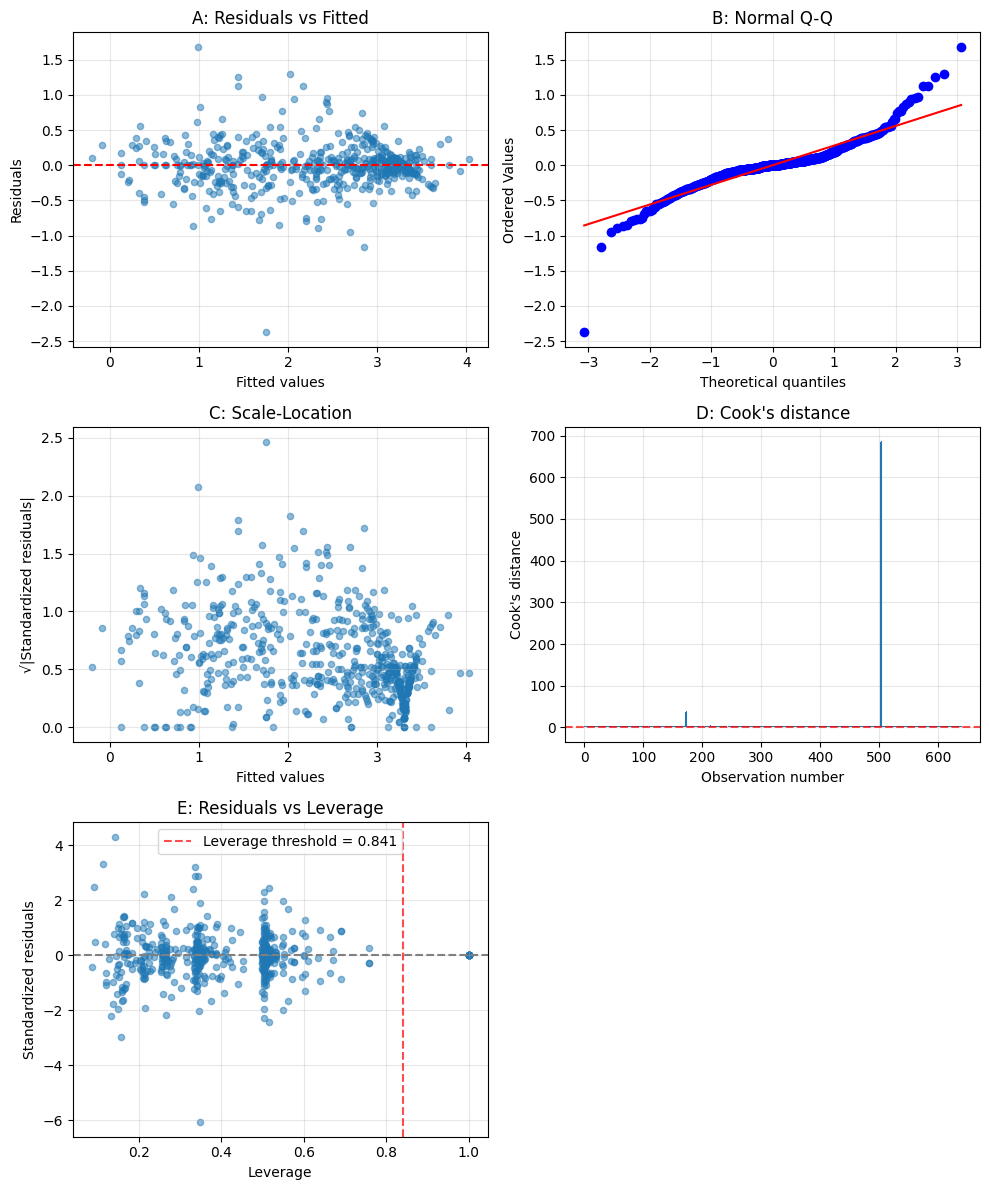

In [ ]:
# ============================================================================
# CELL 4: DIAGNOSTIC PLOTS FOR MODEL VALIDATION
# ============================================================================
# GOAL:
# Create 5 standard diagnostic plots.
#
# These plots replicate Figure 3 from the paper and use the primary MLR model
# fitted on the full dataset.
# ============================================================================

# Create a figure with 5 subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Extract values from our primary MLR model for plotting
# These were calculated in Cell 3
fitted_values = mlr_model.fittedvalues      # Model's predictions for each observation
residuals = mlr_model.resid                 # Residuals (actual - predicted)
standardized_resid = residuals / mlr_rmse   # Standardized residuals (divided by RMSE)

# ==================================
# Plot A: Residuals vs Fitted Values
# ==================================
axes[0,0].scatter(fitted_values, residuals, alpha=0.5, s=20)
axes[0,0].axhline(y=0, color='r', linestyle='--')
axes[0,0].set_xlabel('Fitted values')
axes[0,0].set_ylabel('Residuals')
axes[0,0].set_title('A: Residuals vs Fitted')
axes[0,0].grid(True, alpha=0.3)

# =======================
# Plot B: Normal Q-Q Plot
# =======================
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('B: Normal Q-Q')
axes[0,1].grid(True, alpha=0.3)

# ====================
# Plot C: Scale-Location (Spread-Location)
# ====================
axes[1,0].scatter(fitted_values, np.sqrt(np.abs(standardized_resid)), alpha=0.5, s=20)
axes[1,0].set_xlabel('Fitted values')
axes[1,0].set_ylabel('√|Standardized residuals|')
axes[1,0].set_title('C: Scale-Location')
axes[1,0].grid(True, alpha=0.3)

# ====================
# Plot D: Cook's Distance
# ====================
axes[1,1].stem(range(len(cooks_d)), cooks_d, markerfmt=',', basefmt=' ')
axes[1,1].axhline(y=cook_threshold, color='r', linestyle='--', alpha=0.7,
                  label=f'Threshold = {cook_threshold:.3f}')
axes[1,1].set_xlabel('Observation number')
axes[1,1].set_ylabel("Cook's distance")
axes[1,1].set_title("D: Cook's distance")
axes[1,1].grid(True, alpha=0.3)

# ====================
# Plot E: Residuals vs Leverage
# ====================
axes[2,0].scatter(leverage, standardized_resid, alpha=0.5, s=20)
axes[2,0].axhline(y=0, color='gray', linestyle='--')
axes[2,0].axvline(x=leverage_threshold, color='r', linestyle='--', alpha=0.7,
                  label=f'Leverage threshold = {leverage_threshold:.3f}')
axes[2,0].set_xlabel('Leverage')
axes[2,0].set_ylabel('Standardized residuals')
axes[2,0].set_title('E: Residuals vs Leverage')
axes[2,0].grid(True, alpha=0.3)
axes[2,0].legend()

axes[2,1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# CELL 5: LEAVE-ONE-OUT ANALYSIS
# ============================================================================
# GOAL:
# We are testing how important each of our predictor variables is. To do this,
# we remove one variable at a time and see how it affects the model's performance.
#
# METHOD:
# For each variable, we perform a clear, three-step process:
# 1. Fit the reduced model (with the variable removed).
# 2. Compare it to the full model to get a p-value using an F-test.
# 3. Calculate the performance metrics (MSE and % explained).
# ============================================================================

# Print the table header
print("\n" + "="*60)
print("TABLE 4: LEAVE-ONE-OUT REGRESSION MODELING")
print("="*60)
print(f"{'Model Parameters (Removed)':<30} {'MSE':<10} {'% exp':<10} {'p-value'}")
print("-"*60)

# Print the baseline (full model) results for comparison
print(f"{'All':<30} {mlr_mse:<10.3f} {mlr_pct:<10.1f} {'-':<12}")

# --- (Chemical) ---
# Fit the reduced model.
reduced_model = ols('log10 ~ -1 + C(species) + C(source) + purity_centered',
                    data=mlr_data).fit()
# Compare to the full model to get the p-value.
p_value = sm.stats.anova_lm(reduced_model, mlr_model)['Pr(>F)'].iloc[1]
# Calculate metrics for this model.
mse = reduced_model.mse_resid
pct_exp = ((mlr_variance - mse) / mlr_variance) * 100
# Format the p-value and print the results for this row.
print(f"{'(Chemical)':<30} {mse:<10.3f} {pct_exp:<10.1f} {p_value:.3e}")


# --- (Species) ---
reduced_model = ols('log10 ~ -1 + C(casrn) + C(source) + purity_centered',
                    data=mlr_data).fit()
p_value = sm.stats.anova_lm(reduced_model, mlr_model)['Pr(>F)'].iloc[1]
mse = reduced_model.mse_resid
pct_exp = ((mlr_variance - mse) / mlr_variance) * 100
print(f"{'(Species)':<30} {mse:<10.3f} {pct_exp:<10.1f} {p_value:.3e}")


# --- (Source) ---
reduced_model = ols('log10 ~ -1 + C(casrn) + C(species) + purity_centered',
                    data=mlr_data).fit()
p_value = sm.stats.anova_lm(reduced_model, mlr_model)['Pr(>F)'].iloc[1]
mse = reduced_model.mse_resid
pct_exp = ((mlr_variance - mse) / mlr_variance) * 100
print(f"{'(Source)':<30} {mse:<10.3f} {pct_exp:<10.1f} {p_value:.3e}")


# --- (Purity) ---
reduced_model = ols('log10 ~ -1 + C(casrn) + C(species) + C(source)',
                    data=mlr_data).fit()
p_value = sm.stats.anova_lm(reduced_model, mlr_model)['Pr(>F)'].iloc[1]
mse = reduced_model.mse_resid
pct_exp = ((mlr_variance - mse) / mlr_variance) * 100
print(f"{'(Purity)':<30} {mse:<10.3f} {pct_exp:<10.1f} {p_value:.3e}")


TABLE 4: LEAVE-ONE-OUT REGRESSION MODELING
Model Parameters (Removed)     MSE        % exp      p-value
------------------------------------------------------------
All                            0.153      83.9       -           
(Chemical)                     0.770      19.1       1.780e-91
(Species)                      0.165      82.7       3.644e-03
(Source)                       0.154      83.8       7.926e-02
(Purity)                       0.161      83.1       9.783e-06


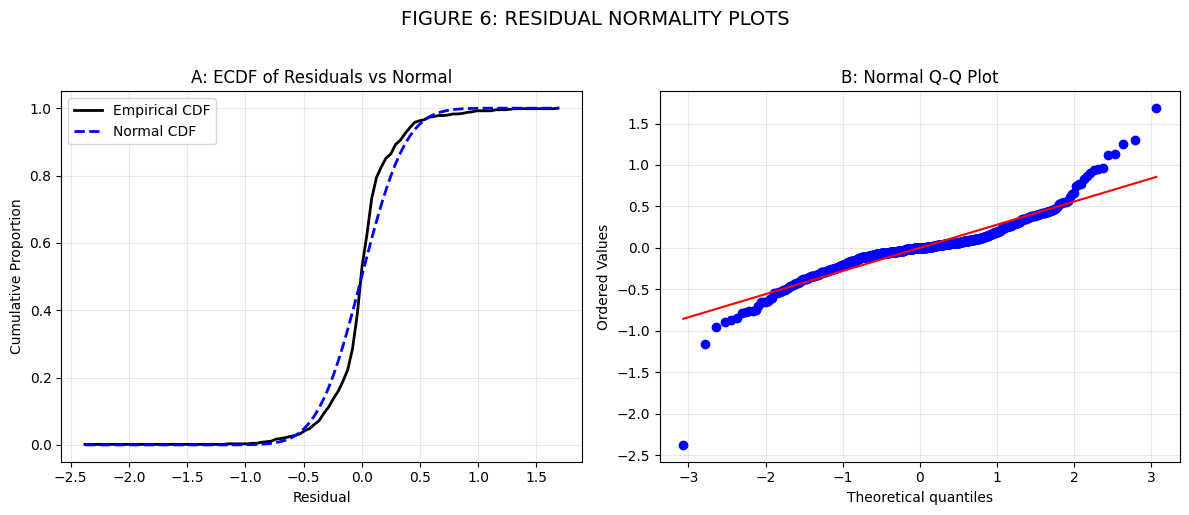


STATISTICAL TESTS ON RESIDUALS
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
Skewness:                  -0.205   # Near zero: errors are symmetric
Excess Kurtosis:            9.913   # High: many extreme outliers
K-S Test p-value:           0.0000  # Very low: residuals are not normal

EMPIRICAL 95% RANGE OF RESIDUALS
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
2.5th Percentile:          -0.613      # Lower bound of typical error
97.5th Percentile:          0.613      # Upper bound of typical error
Width of 95% range:         16.81-fold # Typical prediction uncertainty


In [ ]:
# ============================================================================
# CELL 6: STATISTICAL TESTS ON RESIDUALS AND ECDF PLOTS
# ============================================================================
# GOAL:
# This cell evaluates whether the residuals from our main MLR model
# follow a normal distribution. This is important because the validity of
# prediction intervals based on RMSE depends on this assumption.
#
# METHOD:
# 1. Calculate skewness and excess kurtosis to describe the
#    shape of the residual distribution.
# 2. Perform the K-S test to test for normality.
# 3. Compute the empirical 2.5th and 97.5th percentiles of the residuals to
#    determine the actual range containing 95% of errors.
# 4. Visualize the residual distribution using ECDF and Q-Q plots.
# ============================================================================

from scipy.stats import skew, kurtosis, kstest
from statsmodels.distributions.empirical_distribution import ECDF

# --- Obtain residuals from the main MLR model ---
residuals = mlr_model.resid

# --- 1. Calculate distribution shape metrics ---

# Skewness: Measures asymmetry of the distribution.
# Formula: mean((residual - mean(residual))**3) / std(residual)**3
# Value near 0 indicates symmetry.
residual_skewness = skew(residuals)

# Excess Kurtosis: Measures tail heaviness relative to normal.
# Formula: mean((residual - mean(residual))**4) / std(residual)**4 - 3
# Value near 0 indicates normal tails; positive = heavy tails.
excess_kurtosis = kurtosis(residuals)

# --- 2. Kolmogorov-Smirnov (K-S) test for normality ---

# The K-S test compares the empirical distribution of residuals to a normal distribution
# with the same mean and standard deviation.
# Null hypothesis: residuals are normally distributed.
ks_statistic, ks_pvalue = kstest(
    residuals,
    'norm',
    args=(residuals.mean(), residuals.std())
)

# --- 3. Empirical percentiles for 95% range ---

# The 2.5th and 97.5th percentiles define the interval containing the central 95% of residuals.
lower_percentile, upper_percentile = np.percentile(residuals, [2.5, 97.5])

# The width of this range in fold (not log10 units):
# Formula: 10**(upper_percentile) / 10**(lower_percentile)
empirical_width = 10**upper_percentile / 10**lower_percentile

# --- 4. Visualize residual distribution ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ECDF plot: compares empirical CDF of residuals to theoretical normal CDF
ecdf = ECDF(residuals)
x_range = np.linspace(residuals.min(), residuals.max(), 100)
ax1.plot(x_range, ecdf(x_range), 'k-', label='Empirical CDF', lw=2)
ax1.plot(x_range, stats.norm.cdf(x_range, residuals.mean(), residuals.std()), 'b--', label='Normal CDF', lw=2)
ax1.set_title('A: ECDF of Residuals vs Normal')
ax1.set_xlabel('Residual')
ax1.set_ylabel('Cumulative Proportion')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Q-Q plot: compares quantiles of residuals to quantiles of normal distribution
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('B: Normal Q-Q Plot')
ax2.grid(True, alpha=0.3)

plt.suptitle('FIGURE 6: RESIDUAL NORMALITY PLOTS', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# --- 5. Print summary of results ---
print("\nSTATISTICAL TESTS ON RESIDUALS")
print("–"*71)
print(f"Skewness:                {residual_skewness:>8.3f}   # Near zero: errors are symmetric")
print(f"Excess Kurtosis:         {excess_kurtosis:>8.3f}   # High: many extreme outliers")
print(f"K-S Test p-value:         {ks_pvalue:>8.4f}  # Very low: residuals are not normal")

print("\nEMPIRICAL 95% RANGE OF RESIDUALS")
print("–"*71)
print(f"2.5th Percentile:        {lower_percentile:>8.3f}      # Lower bound of typical error")
print(f"97.5th Percentile:       {upper_percentile:>8.3f}      # Upper bound of typical error")
print(f"Width of 95% range:      {empirical_width:>8.2f}-fold # Typical prediction uncertainty")

In [ ]:
# ============================================================================
# CELL 7: CALCULATING MINIMUM PREDICTION INTERVALS (TABLE 6)
# ============================================================================
# Calculate 95% prediction intervals for all models using two methods:
# 1. Empirical: Uses actual residual percentiles (for non-normal residuals)
# 2. RMSE-based: Uses formula ±1.96 × RMSE (assumes normal residuals)
# ============================================================================

# Collect all model results
models = [
    {'Method': 'ECDF of MLR residuals', 'Dataset': 'full dataset', 'RMSE': np.nan},
    {'Method': 'MLR', 'Dataset': 'full dataset', 'RMSE': mlr_rmse},
    {'Method': 'RLR', 'Dataset': 'full dataset', 'RMSE': rlr_rmse},
    {'Method': 'MLR', 'Dataset': 'high leverage removed', 'RMSE': rmse3},
    {'Method': 'MLR', 'Dataset': 'high Cooks plot removed', 'RMSE': rmse4},
    {'Method': 'MLR', 'Dataset': 'high Cooks removed', 'RMSE': rmse5},
    {'Method': 'MLR', 'Dataset': 'all outliers removed', 'RMSE': rmse6},
    {'Method': 'ACM', 'Dataset': 'full cell dataset', 'RMSE': acm_rmse},
    {'Method': 'MLR', 'Dataset': 'full cell dataset', 'RMSE': mlr_acm_rmse}
]

# Calculate intervals for each model
table_data = []
for model in models:
    if model['Method'] == 'ECDF of MLR residuals':
        # Use empirical percentiles
        width = 10**(upper_percentile - lower_percentile)
        lb_factor = 10**lower_percentile
        ub_factor = 10**upper_percentile
    else:
        # Use RMSE-based formula
        width = 10**(1.96 * model['RMSE'] * 2)
        lb_factor = 10**(-1.96 * model['RMSE'])
        ub_factor = 10**(1.96 * model['RMSE'])

    # Calculate bounds for three test values
    table_data.append({
        'Method': model['Method'],
        'Dataset': model['Dataset'],
        'RMSE': model['RMSE'],
        'Width (fold)': width,
        '1 mg/kg LB': 1 * lb_factor, '1 mg/kg UB': 1 * ub_factor,
        '10 mg/kg LB': 10 * lb_factor, '10 mg/kg UB': 10 * ub_factor,
        '100 mg/kg LB': 100 * lb_factor, '100 mg/kg UB': 100 * ub_factor,
    })

# Create and display table
df_table6 = pd.DataFrame(table_data).sort_values('RMSE', na_position='first')
pd.options.display.float_format = '{:,.2f}'.format

print("\n" + "="*100)
print("TABLE 6: ESTIMATED PREDICTION INTERVALS")
print("="*100)
print(df_table6.to_string(index=False))

# Summary
best_rmse = df_table6.loc[df_table6['RMSE'].notna(), 'RMSE'].min()
narrowest_width = df_table6.loc[df_table6['RMSE'].notna(), 'Width (fold)'].min()
print("\n" + "-"*60)
print(f"Best RMSE: {best_rmse:.3f} log10 units")
print(f"Narrowest interval: {narrowest_width:.0f}-fold")
print("-"*60)
print("""\nIf the true toxicity is 10 mg/kg, what range might our model predict?
The table shows it could be anywhere from 2.44 to 41.01 mg/kg.""")


TABLE 6: ESTIMATED PREDICTION INTERVALS
               Method                 Dataset  RMSE  Width (fold)  1 mg/kg LB  1 mg/kg UB  10 mg/kg LB  10 mg/kg UB  100 mg/kg LB  100 mg/kg UB
ECDF of MLR residuals            full dataset   NaN         16.81        0.24        4.10         2.44        41.01         24.40        410.14
                  MLR      high Cooks removed  0.29         14.31        0.26        3.78         2.64        37.83         26.44        378.28
                  MLR    all outliers removed  0.29         14.31        0.26        3.78         2.64        37.83         26.44        378.28
                  MLR high Cooks plot removed  0.39         34.16        0.17        5.84         1.71        58.45         17.11        584.49
                  MLR            full dataset  0.39         34.16        0.17        5.84         1.71        58.45         17.11        584.49
                  MLR   high leverage removed  0.39         34.16        0.17        5.84      

**Interpretation of Table 6:**

The first row ("ECDF of MLR residuals") uses the **empirical method** to calculate prediction intervals. In this approach, we take all the residuals (the differences between predicted and actual values) from the model, sort them, and then identify the 2.5th and 97.5th percentiles. These percentiles define the lower and upper bounds of the interval that contains 95% of the model’s errors. For any true value (e.g., 10 mg/kg), the prediction interval is calculated as `10 * 10^(lower_percentile)` to `10 * 10^(upper_percentile)`. The width of this interval is the ratio `10^(upper_percentile - lower_percentile)`. This method does not use RMSE, which is why the first row has no RMSE value.

All other rows use the **RMSE-based method**. Here, we first calculate the RMSE (root mean squared error) from the model’s residuals. Assuming the residuals follow a normal distribution, the 95% prediction interval for a true value is computed as `True Value * 10^(-1.96 * RMSE)` to `True Value * 10^(+1.96 * RMSE)`, and the width is `10^(1.96 * RMSE * 2)`. Each of these rows reports the RMSE used in the calculation.

We report both methods because the RMSE-based approach is only valid if the residuals are normally distributed. If the residuals are not normal, the RMSE-based interval can be misleading. In our analysis, the residuals for the main model are not normal (as shown by the K-S test and high kurtosis), so the empirical interval is a more reliable measure of prediction uncertainty. However, we did not check the normality assumption for every model in the table, so the RMSE-based intervals for those models should be interpreted with caution.

---

### **Practical Example:**

Let's use your best model (`MLR high Cooks removed`), which has an **RMSE of 0.29**.

#### **The Prediction:**

The model's single best guess for a new chemical is LD50 of **30**.

#### **Calculating the 95% Prediction Interval:**

We use the following formulas to find the range of uncertainty around this prediction:
*   **Lower Bound (LB):** `True Value × 10^(-1.96 × RMSE)`
*   **Upper Bound (UB):** `True Value × 10^(+1.96 × RMSE)`

Plugging in the numbers:
*   **Lower Bound:** `30 * 10^(-1.96 * 0.29)` = `30 * 10^(-0.5684)` = `30 * 0.27` = **8.1**
*   **Upper Bound:** `30 * 10^(+1.96 * 0.29)` = `30 * 10^(+0.5684)` = `30 * 3.70` = **111.0**

#### **Calculating the Fold Width:**

The fold width is the total span of this uncertainty range.

*   **Fold Width:** `Upper Bound / Lower Bound` = `111,0 / 8,1` ≈ **14-fold** (always the same, no matter the predicted value)

---

### **What This Means in Practice:**

> "Our model predicts an LD50 of **30 mg/kg**. However, due to inherent data variability, we are 95% confident that the chemical's true LD50 value is between **8,1 mg/kg and 111,0 mg/kg**."